# NFL Spreads Analysis - Load and clean data

## Load current NFL Spread data data from: 
https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data
- Will need to provide kaggle id and token

In [1]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data")

100%|██████████| 247k/247k [00:00<00:00, 2.89MB/s]

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

## Load csv files

In [5]:
teams = pd.read_csv('nfl-scores-and-betting-data/nfl_teams.csv',header=0)
games = pd.read_csv('nfl-scores-and-betting-data/spreadspoke_scores.csv',header=0)

In [6]:
teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
2,Baltimore Colts,Colts,IND,CLT,AFC,NaN,AFC,AFC East
3,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
4,Boston Patriots,Patriots,NE,NWE,AFC,NaN,AFC,NaN


In [7]:
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


## Preprocess dataframes

In [8]:
# drop games without a spread
games = games.dropna(subset=['over_under_line', 'spread_favorite'])

In [9]:
# we will choose to analyze data since the 2002 season
games = games[games['schedule_season'] > 2002]

In [10]:
# convert schedule to datetime type
games['schedule_date'] = pd.to_datetime(games['schedule_date'])
games.sort_values(by=['schedule_date'], inplace=True)

In [11]:
# create day of week and month columns
games['day_of_week'] = games['schedule_date'].dt.day_name()
games['month'] = games['schedule_date'].dt.month_name()

In [12]:
# replace string weeks with ints (easier to graph/analyze trends)
# dict of values to be replaced
week_mapping = {
    'Wildcard': 19,
    'Division': 20,
    'Conference': 21,
    'Superbowl': 22
}
# peplace values in the schedule_week column using the dict
games['schedule_week'] = games['schedule_week'].replace(week_mapping)
# convert schedule_week column to ints
games['schedule_week'] = pd.to_numeric(games['schedule_week'], errors='coerce')

## Create variables for spread analysis

In [13]:
# create score difference and score total columns, these will be used to decide what side of bet won for each game
games['score_diff'] = games['score_home'] - games['score_away']
games['score_total'] = games['score_home'] + games['score_away']
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,day_of_week,month,score_diff,score_total
8139,2003-09-04,2003,1,False,Washington Redskins,16.0,13.0,New York Jets,WAS,-3.0,...,FedEx Field,False,74.0,9.0,89.0,NaN,Thursday,September,3.0,29.0
8153,2003-09-07,2003,1,False,Tennessee Titans,25.0,20.0,Oakland Raiders,TEN,-3.5,...,Nissan Stadium,False,70.0,6.0,72.0,NaN,Sunday,September,5.0,45.0
8152,2003-09-07,2003,1,False,Seattle Seahawks,27.0,10.0,New Orleans Saints,SEA,-3.0,...,CenturyLink Field,False,62.0,10.0,81.0,NaN,Sunday,September,17.0,37.0
8151,2003-09-07,2003,1,False,San Francisco 49ers,49.0,7.0,Chicago Bears,SF,-6.5,...,Candlestick Park,False,63.0,15.0,75.0,NaN,Sunday,September,42.0,56.0
8149,2003-09-07,2003,1,False,New York Giants,23.0,13.0,St. Louis Rams,LAR,-1.0,...,Giants Stadium,False,72.0,6.0,55.0,NaN,Sunday,September,10.0,36.0


In [14]:
# replace team_home and team_away with team_ids (used in favorite_id)
games['team_home'] = games.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
games['team_away'] = games.team_away.map(teams.set_index('team_name')['team_id'].to_dict())
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,day_of_week,month,score_diff,score_total
8139,2003-09-04,2003,1,False,WAS,16.0,13.0,NYJ,WAS,-3.0,...,FedEx Field,False,74.0,9.0,89.0,NaN,Thursday,September,3.0,29.0
8153,2003-09-07,2003,1,False,TEN,25.0,20.0,LVR,TEN,-3.5,...,Nissan Stadium,False,70.0,6.0,72.0,NaN,Sunday,September,5.0,45.0
8152,2003-09-07,2003,1,False,SEA,27.0,10.0,NO,SEA,-3.0,...,CenturyLink Field,False,62.0,10.0,81.0,NaN,Sunday,September,17.0,37.0
8151,2003-09-07,2003,1,False,SF,49.0,7.0,CHI,SF,-6.5,...,Candlestick Park,False,63.0,15.0,75.0,NaN,Sunday,September,42.0,56.0
8149,2003-09-07,2003,1,False,NYG,23.0,13.0,LAR,LAR,-1.0,...,Giants Stadium,False,72.0,6.0,55.0,NaN,Sunday,September,10.0,36.0


In [15]:
#change spread favorite to be positive when team is home (since our score difference is home - away)
games['spread_favorite'] = np.where(games['team_favorite_id'] == games['team_home'], np.abs(games['spread_favorite']), games['spread_favorite'])
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,day_of_week,month,score_diff,score_total
8139,2003-09-04,2003,1,False,WAS,16.0,13.0,NYJ,WAS,3.0,...,FedEx Field,False,74.0,9.0,89.0,NaN,Thursday,September,3.0,29.0
8153,2003-09-07,2003,1,False,TEN,25.0,20.0,LVR,TEN,3.5,...,Nissan Stadium,False,70.0,6.0,72.0,NaN,Sunday,September,5.0,45.0
8152,2003-09-07,2003,1,False,SEA,27.0,10.0,NO,SEA,3.0,...,CenturyLink Field,False,62.0,10.0,81.0,NaN,Sunday,September,17.0,37.0
8151,2003-09-07,2003,1,False,SF,49.0,7.0,CHI,SF,6.5,...,Candlestick Park,False,63.0,15.0,75.0,NaN,Sunday,September,42.0,56.0
8149,2003-09-07,2003,1,False,NYG,23.0,13.0,LAR,LAR,-1.0,...,Giants Stadium,False,72.0,6.0,55.0,NaN,Sunday,September,10.0,36.0


In [16]:
# create straight up winner and loser column
games['winner'] = np.where(games['score_home'] >= games['score_away'], games['team_home'], games['team_away'])
games['loser'] = np.where(games['score_home'] >= games['score_away'], games['team_away'], games['team_home'])
# account for ties
games.loc[games['score_diff']==0, 'winner']= 'TIE'
games.loc[games['score_diff']==0, 'loser']= 'TIE'

In [17]:
# create spread winner and losers
games['spread_winner'] = np.where(games['spread_favorite'] > games['score_diff'], games['team_away'], games['team_home'])
games['spread_loser'] = np.where(games['spread_favorite'] < games['score_diff'], games['team_away'], games['team_home'])
# account for push
games.loc[games['score_diff']==games['spread_favorite'], 'spread_winner']= 'PUSH'
games.loc[games['score_diff']==games['spread_favorite'], 'spread_loser']= 'PUSH'

In [18]:
# create over_under winner
games['over_under_line'] = pd.to_numeric(games['over_under_line'], errors='coerce')
games['over_under_winner'] = np.where(games['score_total'] > games['over_under_line'], 'OVER', 'UNDER')
games.loc[games['score_total'] == games['over_under_line'], 'over_under_winner']= 'PUSH'


In [19]:
#create ou line - score_difference column
games['over_under_diff'] = games['score_total'] - games['over_under_line']

In [20]:
#drop schedule_date column since we no longer need it
games.reset_index(drop=True, inplace=True)
games.drop(columns=['schedule_date'], inplace=True)

In [21]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5513 entries, 0 to 5512
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_season      5513 non-null   int64  
 1   schedule_week        5513 non-null   int64  
 2   schedule_playoff     5513 non-null   bool   
 3   team_home            5513 non-null   object 
 4   score_home           5513 non-null   float64
 5   score_away           5513 non-null   float64
 6   team_away            5513 non-null   object 
 7   team_favorite_id     5513 non-null   object 
 8   spread_favorite      5513 non-null   float64
 9   over_under_line      5513 non-null   float64
 10  stadium              5513 non-null   object 
 11  stadium_neutral      5513 non-null   bool   
 12  weather_temperature  4655 non-null   float64
 13  weather_wind_mph     4650 non-null   float64
 14  weather_humidity     2111 non-null   float64
 15  weather_detail       1636 non-null   o

## Perform EDA

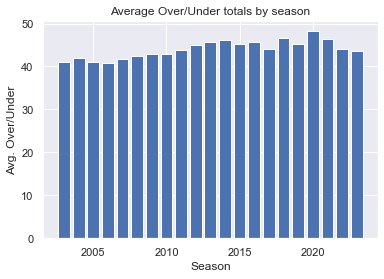

In [22]:
#calculate average over/under by season
ou_season = pd.DataFrame(games.groupby('schedule_season')['over_under_line'].mean())
plt.bar(ou_season.index, ou_season['over_under_line'])
plt.xlabel("Season")
plt.ylabel("Avg. Over/Under")
plt.title("Average Over/Under totals by season")
plt.show()

#### Overall, since 2002 season, over/unders have increased although we have seen a slight decrease since an all-time high in the 2020 season

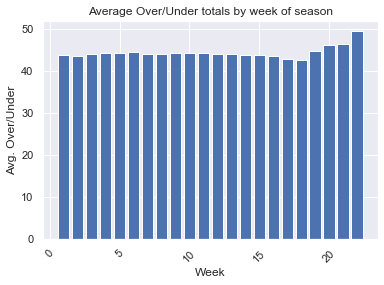

In [23]:
#calculate average over/under by week
ou_week = pd.DataFrame(games.groupby('schedule_week')['over_under_line'].mean())
plt.bar(ou_week.index, ou_week['over_under_line'])
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.ylabel("Avg. Over/Under")
plt.title("Average Over/Under totals by week of season")
plt.show()

#### Over/unders seem to decline throughout the season until the playoffs begin at which point it rises every week, on average. The Super Bowl has the highest average of over/unders.

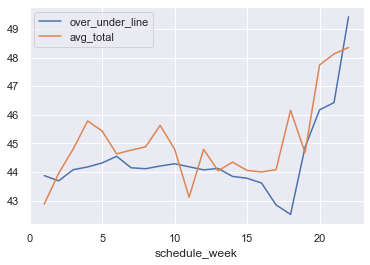

In [24]:
#calculate average over/under by week
ou_week = pd.DataFrame(games.groupby('schedule_week')['over_under_line'].mean())
tot_week = pd.DataFrame(games.groupby('schedule_week')['score_total'].mean())
ou_week['avg_total'] = tot_week['score_total']

ou_week.plot(y = ['over_under_line', 'avg_total'], use_index=True)
plt.show()

#### On a week to week basis, over/unders are much more consistent than average scoring.

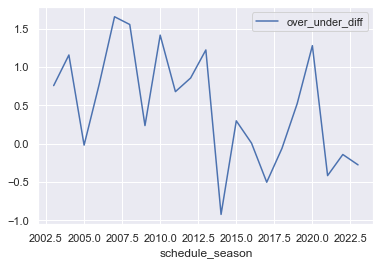

In [25]:
ou_diff_season = pd.DataFrame(games.groupby('schedule_season')['over_under_diff'].mean())
ou_diff_season.plot(y = ['over_under_diff'], use_index=True)
plt.show()

#### Average over/under difference (total - over/under line) is positive generally positive from 2002-2012. This means overs were more likely to hit in those years. It has been random year-to-year from 2012 onward generally

#### Save df to use in python file

In [26]:
games.to_csv("/Users/thomassullivan/PersonalProjects/NFLspreads/games.csv")